# Solving Sod Problem with PINN-WE


* This code is modified from the code https://github.com/alexpapados/Physics-Informed-Deep-Learning-Solid-and-Fluid-Mechanics

* The paper about this code can be reffed to https://www.researchgate.net/publication/359480166_Discontinuity_Computing_with_Physics-Informed_Neural_Network

* For strong shock waves, PINN-WE can let you get a discontinuous result quickly and sharply. But it can not guarantee the result must be physical. You can try to change the random seed or learning rate to get a different result. In the paper, we show the best result of some tests to demonstrate that PINN-WE has the potential ability to handle a non-linear discontinuous problem.

* So physics constraints are needed near shock waves. They are conservation laws, Rankine-Hugoniot relations and entropy condition. We develop a physics screen method here to determinate the problem.


In [10]:
def train(epoch):
    def closure():
        optimizer.zero_grad()                                                     
        loss_pde = model.loss_pde(x_int,x_screen2_L,x_screen2_R,0.01)                                    
        loss_ic = model.loss_ic(x_ic, rho_ic,u_ic,p_ic)   
        loss_bc = model.loss_ic(x_bc, rho_bc,u_bc,p_bc)   
        
        loss_rh1 = model.loss_rh(x_screen2,x_screen2_L,x_screen2_R) # RH relation
        loss_s0 = model.loss_character(x_screen2,x_screen2_R) # Entropy condition
       # loss_con3 = model.loss_con(x_screen3 ,x_ic,T3) #Conservation laws
        loss_con1 = model.loss_con(x_screen1 ,x_ic,T1) #Conservation laws
        loss = loss_pde + 10*(loss_ic+loss_bc) #+  10*(loss_rh1 +loss_con1  )   +10* loss_s0  
       # print(f'epoch {epoch} loss_pde:{loss_pde:.8f},loss_rh1:{loss_rh1:.8f},loss_con:{loss_con1:.8f}, loss_s:{loss_s0:.8f}, loss_ic:{loss_ic:.8f}')
        loss.backward()
        return loss
    loss = optimizer.step(closure)
    return loss

In [71]:
def Unit_var(rhoL,uL,pL,rhoR,uR,pR,t):
  rhoref = max(rhoL,rhoR)
  pmax = max(pL,pR)
  umax = max(abs(uL),abs(uR))
  uref = max(np.sqrt(pmax/rhoref),umax)
  pref = uref**2*rhoref

  
  uLn = (uL)/uref
  uRn = (uR)/uref
  pLn = pL/pref
  pRn = pR/pref
  rhoLn = rhoL/rhoref
  rhoRn = rhoR/rhoref
  
  tn = t*uref
  
  return rhoLn,uLn,pLn,rhoRn,uRn,pRn, tn,rhoref,uref,pref

In [72]:
import torch
import torch.nn as nn
import numpy as np
import time
import scipy.io
dtype=torch.float32
dtype=torch.float64
# Seeds
#crhoL = 1
#cuL = -2
#cpL = 0.4
#
#crhoR =1
#cuR = 2
#cpR = 0.4
#Ts = 0
#Te = 0.1
#rhoref = 1
#uref = 1
#pref = 1
crhoL = 27/7
cuL = 2.629369
cpL = 31/3

crhoR = 1
cuR = 0
cpR = 1

#crhoL = 0.89
#cuL = 0.098923
#cpL = 1
#
#crhoR = 1
#cuR = 0
#cpR = 0.16185
#
#Ts = 0
#Te = 0.91728

Ts = 0
Te = 0.18
Xs = 0
Xe = 1

crhoL,cuL,cpL,crhoR,cuR,cpR,Te,rhoref,uref,pref = Unit_var(crhoL,cuL,cpL,crhoR,cuR,cpR,Te)

###Ts = 0, Xs =0, Xe = 1

#crhoL = 0.89
#cuL = 0.098923
#cpL = 1
#
#crhoR = 1
#cuR = 0
#cpR = 0.16185
#
#Ts = 0
#Te = 0.91728

Xs = 0
Xe = 1
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True

setup_seed(5)
   
def gradients(outputs, inputs):
    return torch.autograd.grad(outputs, inputs,grad_outputs=torch.ones_like(outputs), create_graph=True)

# Convert torch tensor into np.array
def to_numpy(input):
    if isinstance(input, torch.Tensor):
        return input.detach().cpu().numpy()
    elif isinstance(input, np.ndarray):
        return input
    else:
        raise TypeError('Unknown type of input, expected torch.Tensor or ' \
                        'np.ndarray, but got {}'.format(type(input)))

# Initial conditions
def IC(x):
    N = x.shape[0]
    rho_init = np.zeros((x.shape[0]))                                              
    u_init = np.zeros((x.shape[0]))                                                
    p_init = np.zeros((x.shape[0]))                                                

    # rho, p - initial condition
    for i in range(N):
        if (x[i,1] <= 0.2):
            rho_init[i] = crhoL
            u_init[i] = cuL
            p_init[i] = cpL
        else:
            rho_init[i] = crhoR*(1+0.2*np.sin(50*x[i,1]))
            u_init[i] = cuR
            p_init[i] = cpR

    return rho_init, u_init, p_init

def BC(x):
    N = x.shape[0]
    rho_init = np.zeros((x.shape[0]))                                              
    u_init = np.zeros((x.shape[0]))                                                
    p_init = np.zeros((x.shape[0]))                                                

    # rho, p - initial condition
    for i in range(N):
        if (x[i,1] <= 0.2):
            rho_init[i] = crhoL
            u_init[i] = cuL
            p_init[i] = cpL
        else:
            rho_init[i] = crhoR#*(1+0.2*np.sin(50))
            u_init[i] = cuR
            p_init[i] = cpR

    return rho_init, u_init, p_init


# Generate Neural Network
class DNN(nn.Module):

    def __init__(self):
        super(DNN, self).__init__()
        self.net = nn.Sequential()                                                  
        self.net.add_module('Linear_layer_1', nn.Linear(2, 30))                     
        self.net.add_module('Tanh_layer_1', nn.Tanh())                              

        for num in range(2, 7):                                                     
            self.net.add_module('Linear_layer_%d' % (num), nn.Linear(30, 30))       
            self.net.add_module('Tanh_layer_%d' % (num), nn.Tanh())                 
        self.net.add_module('Linear_layer_final', nn.Linear(30, 3))                 

    # Forward Feed
    def forward(self, x):
        return self.net(x)

    # Loss function for PDE
    def loss_pde(self, x,xL,xR,Dx):
        y = self.net(x)                                                
        rho,p,u = y[:, 0:1], y[:, 1:2], y[:, 2:]
        
        yR = self.net(xR)                                                
        rhoR,pR,uR = yR[:, 0:1], yR[:, 1:2], yR[:, 2:]
        yL = self.net(xL)                                                
        rhoL,pL,uL = yL[:, 0:1], yL[:, 1:2], yL[:, 2:]
        
        U2 = rho*u
        U3 = 0.5*rho*u**2 + p/0.4
        
        #F1 = U2
        F2 = rho*u**2+p
        F3 = u*(U3 + p)
        
        gamma = 1.4                                                    

        # Gradients and partial derivatives
        drho_g = gradients(rho, x)[0]                                  
        rho_t, rho_x = drho_g[:, :1], drho_g[:, 1:]             


        du_g = gradients(u, x)[0]                                      
        u_t, u_x = du_g[:, :1], du_g[:, 1:]                            
        
        dp_g = gradients(p, x)[0]                                      
        p_t, p_x = dp_g[:, :1], dp_g[:, 1:]                            

       # dp_g = gradients(p, x)[0]                                     
       # p_t, p_x = dp_g[:, :1], dp_g[:, 1:]                           
        
        dU2_g = gradients(U2, x)[0]
        U2_t,U2_x = dU2_g[:,:1], dU2_g[:,1:]
        dU3_g = gradients(U3, x)[0]
        U3_t,U3_x = dU3_g[:,:1], dU3_g[:,1:]
        dF2_g = gradients(F2, x)[0]
        F2_t,F2_x = dF2_g[:,:1], dF2_g[:,1:]
        dF3_g = gradients(F3, x)[0]
        F3_t,F3_x = dF3_g[:,:1], dF3_g[:,1:]

        d1 = 0.4*(abs(u_x)-(u_x) )+1 #+ (torch.sign(0.01 -abs(u_x))+1)*abs(rho_x))+ 1
        d2 = 0.4*(abs(u_x)-(u_x) )+1 #+ (torch.sign(0.01 -abs(u_x))+1)*abs(rho_x))+ 1
        d3 = 0.4*(abs(u_x)-(u_x) )+1 #+ (torch.sign(0.01 -abs(u_x))+1)*abs(rho_x))+ 1
        
        #d = 0.1*(abs(uR-uL)-(uR-uL))/Dx + 1
        #d = torch.exp(-10*u_x)+1
        #d1 = torch.clamp(d/5,min=1)
     
        f = (((rho_t + U2_x)/d1)**2).mean() + \
            (((U2_t  + F2_x)/d2)**2).mean() + \
            (((U3_t  + F3_x)/d3)**2).mean() #+\
            #((rho_t).mean())**2 +\
            #((U3_t).mean())**2 
    
        return f

    def loss_ic(self, x, rho, u, p):
        y = self.net(x)                                                      
        rho_nn, p_nn,u_nn = y[:, 0], y[:, 1], y[:, 2]            

        loss_ics = ((u_nn - u) ** 2).mean() + \
               ((rho_nn- rho) ** 2).mean()  + \
               ((p_nn - p) ** 2).mean()

        return loss_ics
    
    # Loss function for conservation
    def loss_con(self, x_en,x_in,t):
        y_en = self.net(x_en)                                       
        y_in = self.net(x_in)                                       
        rhoen, pen,uen = y_en[:, 0], y_en[:, 1], y_en[:, 2]         
        rhoin, pin,uin = y_in[:, 0], y_in[:, 1], y_in[:, 2]         

        U3en = 0.5*rhoen*uen**2 + pen/0.4
        U3in = 0.5*rhoin*uin**2 + pin/0.4
        gamma = 1.4
        cU3L = 0.5*crhoL*cuL**2 + cpL/0.4 
        cU3R = 0.5*crhoR*cuR**2 + cpR/0.4 
        # Loss function for the initial condition
        loss_en = ((rhoen - rhoin).mean() - t*(crhoL*cuL-crhoR*cuR))**2+ \
            ((-U3en+ U3in).mean() + t*(cU3L*cuL - cU3R*cuR) + (cpL*cuL - cpR*cuR)*t )**2 +\
            ((-rhoen*uen + rhoin*uin).mean()+(cpL-cpR)*t +(crhoL*cuL*cuL-crhoR*cuR*cuR)*t)**2
        return loss_en
    
    def loss_rh(self, x,x_l,x_r):
        y = self.net(x)                                    
        y_r = self.net(x_r)                                    
        y_l = self.net(x_l)                                    
        rho, p,u = y[:, 0], y[:, 1], y[:, 2]          
        rhol, pl,ul = y_l[:, 0], y_l[:, 1], y_l[:, 2]          
        rhor, pr,ur = y_r[:, 0], y_r[:, 1], y_r[:, 2]          

        du_g = gradients(u, x)[0]                                      
        u_t, u_x = du_g[:, 0], du_g[:, 1]                            
        d = 1/(0.1*(abs(u_x)-u_x)  + 1)
        eta =  torch.clamp(d-0.1,max=0)*torch.clamp(abs(pr-pl)-0.1,min=0)*torch.clamp(abs(ur-ul)-0.1,min=0)
       # eta =  torch.clamp(abs(pr-pl)-0.1,min=0)*torch.clamp(abs(ur-ul)-0.1,min=0)
        #eta = 1
        
        #loss_rh =  (((rho/rhol - (6*p+pl)/(6*pl+p))*eta)**2).mean()+\
        loss_rh = (((rhor/rhol - (6*pr+pl)/(6*pl+pr))*(ur-ul)*eta)**2).mean()+\
                   ((((ur-ul)**2 -2/rhor*(pr-pl)**2/(0.4*pr+2.4*pl))*eta)**2).mean()
           #        ((((ur-u)**2 -2/rho*(pr-p)**2/(0.4*pr+2.4*p))*eta)**2).max()
            
        #loss_rh =  (((pr/pl - (6*rhor-rhol)/(6*rhol-rhor))*(pr-pl)*eta)**2).max()+\
                   #((((u-ul)**2 -2/rho*(p-pl)**2/(0.4*p+2.4*pl))*eta)**2).max()+\
        return loss_rh
    
    def loss_character(self, x_l,x_r):
        y_r = self.net(x_r)                                                      # Initial condition
        y_l = self.net(x_l)                                                      # Initial condition
        rhol, pl,ul = y_l[:, 0], y_l[:, 1], y_l[:, 2]            # rho, u, p - initial condition
        rhor, pr,ur = y_r[:, 0], y_r[:, 1], y_r[:, 2]            # rho, u, p - initial condition

        #du_g = gradients(ul, x_l)[0]                                      
        #u_t, u_x = du_g[:, :1], du_g[:, 1:]                            
        #d = 1/(0.1*(abs(u_x)-u_x)  + 1)
        #eta =  torch.clamp(d-0.1,max=0)*torch.clamp(abs(pr-pl)-0.01,min=0)*torch.clamp(abs(ur-ul)-0.01,min=0)
        eta =  torch.clamp(abs(pr-pl)-0.01,min=0)*torch.clamp(abs(ur-ul)-0.01,min=0)
       # eta = 1
        # Loss function for the initial condition
        gamma = 1.4
        ss = 1.0e-10
        cL = torch.sqrt(gamma*abs(pl)/(abs(rhol)+ss))
        cR = torch.sqrt(gamma*abs(pr)/(abs(rhor)+ss))
        sR = torch.max(ul+cL,ur+cR)* (rhol-rhor)
        sL = torch.min(ul-cL,ur-cR)*(rhol-rhor)
        
        s = rhol*ul - rhor*ur
       # if (s.max() > 1000):
       #     print(rhol-rhor)
       #     print(s)
        #print(torch.clamp(s-sR,min=0))
       # print(eta)
       # sm = exp(-100*(s-sR))
        loss_s = (((s-sR)*(s-sL)*eta)**2).mean()  #torch.min((((,torch.tensor(1.0))  #+ ((torch.clamp(sL-s,min=0))**2).max()
        return loss_s
        
    
def X_entropy(x,T,dt,dx):
    N=x.shape[0]
    xs   = np.zeros((N,2)) 
    xsL  = np.zeros((N,2)) 
    xsR  = np.zeros((N,2)) 
    xsP  = np.zeros((N,2)) 
    xsPL = np.zeros((N,2)) 
    xsPR = np.zeros((N,2)) 
    
    for i in range(N):
        xs[i,1] = x[i,1]
        xs[i,0] = x[i,0] + T
        xsL[i,1] = xs[i,1] - dx
        xsL[i,0] = xs[i,0]
        xsR[i,1] = xs[i,1] + dx
        xsR[i,0] = xs[i,0]
        xsP[i,0] = xs[i,0] + dt
        xsP[i,1] = xs[i,1]
        xsPL[i,0] = xsP[i,0]
        xsPL[i,1] = xsP[i,1]+ dx
        xsPR[i,0] = xsP[i,0]
        xsPR[i,1] = xsP[i,1]- dx
        
    return xs,xsL,xsR,xsP,xsPL,xsPR


def X_right(x,dx):
    N=x.shape[0]
    xen =np.zeros((N,2)) 
    
    for i in range(N):
        xen[i,1] = x[i,1] + dx
        xen[i,0] = x[i,0] 
    return xen
def bc_data(N,Ts,Te,Xs,Xe):
    x =np.zeros((2*N,2)) 
    
    for i in range(N):
        x[i,0] = (Te - Ts)*i/N
        x[i,1] = Xs
        
    for i in range(N):
        x[i+N,0] = (Te - Ts)*i/N
        x[i+N,1] = Xe
    return x
def Mesh_Data(num_x,num_t,Tstart,Tend, Xstart,Xend):
    x_ic = np.zeros((num_x,2))
    x_int = np.zeros((num_x*(num_t-1),2))
    
    x_bc =np.zeros((2*(num_t-1),2)) 
    
    dt = (Tend - Tstart)/num_t
    x =   np.linspace(Xs, Xe, num_x) 
    x_ic[:,0] = 0
    x_ic[:,1] = x
    t = np.linspace(Tstart+dt, Tend, num_t-1)                                     
    x_bc[:num_t-1,0] = t
    x_bc[:num_t-1,1] = Xstart 
    x_bc[num_t-1:,0] = t
    x_bc[num_t-1:,1] = Xend

    
    t_grid, x_grid = np.meshgrid(t, x)                                 
    T = t_grid.flatten()[:, None]                                      
    X = x_grid.flatten()[:, None]                                      
    x_int = X[:, 0][:,None]                                        
    t_int = T[:, 0][:,None]                                        

    x_int = np.hstack((t_int, x_int))                            
    
    return x_ic,x_bc,x_int
    
    
device = torch.device('cuda')         # change to cpu if you dont have a cuda device                              

Nx = 100
Nt = 100

x_ic,x_bc,x_int =  Mesh_Data(Nx,Nt,Ts,Te,Xs,Xe)
rho_ic, u_ic, p_ic= IC(x_ic)                    
rho_bc, u_bc, p_bc= BC(x_bc)                    

T1 = Te/2
T3 = Te
dx = 0.002
dt = 0.002
x_screen1,x_screen1_L,x_screen1_R,x_screen1_P,x_screen1_PL,x_screen1_PR = X_entropy(x_ic,T1,dt,dx)
x_screen2,x_screen2_L,x_screen2_R,x_screen2_P,x_screen2_PL,x_screen2_PR = X_entropy(x_int,0.0,dt,dx)
x_screen3,x_screen3_L,x_screen3_R,x_screen3_P,x_screen3_PL,x_screen3_PR = X_entropy(x_ic,T3,dt,dx)

x_screen1     = torch.tensor(x_screen1, requires_grad=True, dtype=dtype).to(device)
x_screen1_L   = torch.tensor(x_screen1_L, dtype=dtype).to(device) 
x_screen1_R   = torch.tensor(x_screen1_R, dtype=dtype).to(device)
x_screen1_P   = torch.tensor(x_screen1_P, requires_grad=True, dtype=dtype).to(device)
x_screen1_PL  = torch.tensor(x_screen1_PL, dtype=dtype).to(device)
x_screen1_PR  = torch.tensor(x_screen1_PR, dtype=dtype).to(device)

x_screen2     = torch.tensor(x_screen2, requires_grad=True, dtype=dtype).to(device)
x_screen2_L   = torch.tensor(x_screen2_L, dtype=dtype).to(device)
x_screen2_R   = torch.tensor(x_screen2_R, dtype=dtype).to(device)
x_screen2_P   = torch.tensor(x_screen2_P, requires_grad=True, dtype=dtype).to(device)
x_screen2_PL  = torch.tensor(x_screen2_PL, dtype=dtype).to(device)
x_screen2_PR  = torch.tensor(x_screen2_PR, dtype=dtype).to(device)

x_screen3     = torch.tensor(x_screen3, requires_grad=True, dtype=dtype).to(device)
x_screen3_L   = torch.tensor(x_screen3_L, dtype=dtype).to(device) 
x_screen3_R   = torch.tensor(x_screen3_R, dtype=dtype).to(device)
x_screen3_P   = torch.tensor(x_screen3_P, requires_grad=True, dtype=dtype).to(device)
x_screen3_PL  = torch.tensor(x_screen3_PL, dtype=dtype).to(device)
x_screen3_PR  = torch.tensor(x_screen3_PR, dtype=dtype).to(device)

x_ic = torch.tensor(x_ic,requires_grad=True, dtype=dtype).to(device)
x_bc = torch.tensor(x_bc,requires_grad=True, dtype=dtype).to(device)
x_int = torch.tensor(x_int, requires_grad=True, dtype=dtype).to(device)

rho_ic = torch.tensor(rho_ic, dtype=dtype).to(device)
u_ic = torch.tensor(u_ic, dtype=dtype).to(device)
p_ic = torch.tensor(p_ic, dtype=dtype).to(device)

rho_bc = torch.tensor(rho_bc, dtype=dtype).to(device)
u_bc = torch.tensor(u_bc, dtype=dtype).to(device)
p_bc = torch.tensor(p_bc, dtype=dtype).to(device)


model = DNN().to(device).double()

print('Start training...')


lr = 0.001                                                           # Learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

Start training...


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

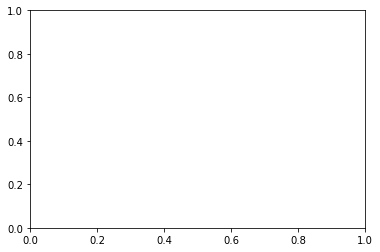

In [73]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(x_ic[:,0],x_ic[:,1])
ax.scatter(x_int[:,0],x_int[:,1])
ax.scatter(x_bc[:,0],x_bc[:,1])
#ax.set_ylim(0.0, 1.2)
plt.show()

In [69]:
y = self.net(x)                                                
rho,p,u = y[:, 0:1], y[:, 1:2], y[:, 2:]

yR = self.net(xR)                                                
rhoR,pR,uR = yR[:, 0:1], yR[:, 1:2], yR[:, 2:]
yL = self.net(xL)                                                
rhoL,pL,uL = yL[:, 0:1], yL[:, 1:2], yL[:, 2:]


    #((rho_t).mean())**2 +\
            #((U3_t).mean())**2 

NameError: name 'self' is not defined

In [70]:
epoch = 0
epochi = epoch
lr = 0.001                                                           # Learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
epochs = 100000
loss_history=[]
tic = time.time()
for epoch in range(1+epochi, epochs+epochi):
    loss = train(epoch)
    print(f'loss_tot:{loss:.8f}')
    loss_history.append(to_numpy(loss))
    if loss < 0.05:
        break
toc = time.time()
print(f'Total training time: {toc - tic}')


loss_tot:23.58134764
loss_tot:23.01200243
loss_tot:22.32074976
loss_tot:21.80192066
loss_tot:21.55181293
loss_tot:21.30648337
loss_tot:21.18238068
loss_tot:21.01631860
loss_tot:20.94342149
loss_tot:20.82401975
loss_tot:20.79072368
loss_tot:20.73824392
loss_tot:20.65542788
loss_tot:20.63283434
loss_tot:20.61937949
loss_tot:20.62642900
loss_tot:20.62746056
loss_tot:20.63827351
loss_tot:20.66220744
loss_tot:20.66767510
loss_tot:20.67535734
loss_tot:20.67605952
loss_tot:20.67677184
loss_tot:20.67659004
loss_tot:20.67667917
loss_tot:20.65827598
loss_tot:20.65213102
loss_tot:20.64980787
loss_tot:20.64896560
loss_tot:20.64500885
loss_tot:20.64305763
loss_tot:20.64452935
loss_tot:20.64361257
loss_tot:20.63841269
loss_tot:20.62650286
loss_tot:20.62588770
loss_tot:20.62456082
loss_tot:20.62729706
loss_tot:20.61711108
loss_tot:20.61001560
loss_tot:20.60929789
loss_tot:20.60621791
loss_tot:20.60595621
loss_tot:20.60569570
loss_tot:20.60536188
loss_tot:20.60503818
loss_tot:20.59832494
loss_tot:20.5

KeyboardInterrupt: 

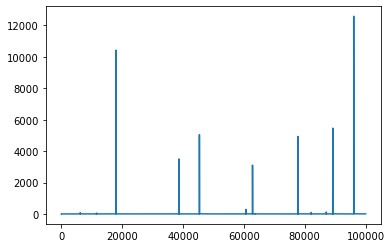

In [62]:
plt.plot(loss_history)

In [63]:
optimizer = torch.optim.LBFGS(model.parameters(),lr=0.01,max_iter=30)
epochi = epoch

epochs = 2000
tic = time.time()
for epoch in range(epochi, epochs+epochi):
    loss = train(epoch)
    print(f'loss_tot:{loss:.8f}')
    loss_history.append(to_numpy(loss))
    #if loss < 0.01:
    #    break
toc = time.time()

print(f'Total training time: {toc - tic}')

loss_tot:3.17274511
loss_tot:3.13270742
loss_tot:3.07688390
loss_tot:3.02613973
loss_tot:2.98181962
loss_tot:2.94680204
loss_tot:2.91414632
loss_tot:3.06230407
loss_tot:2.77548371
loss_tot:2.74152829
loss_tot:2.69082647
loss_tot:2.57624072
loss_tot:2.54143499
loss_tot:2.48075613
loss_tot:2.44522605
loss_tot:2.34865966
loss_tot:2.15176825
loss_tot:1.84098094
loss_tot:30.28656618
loss_tot:13.77965908
loss_tot:5.72573749
loss_tot:7.11731168
loss_tot:4.52256112
loss_tot:3.20572297
loss_tot:2.54340219
loss_tot:1.91947034
loss_tot:1.67265388
loss_tot:1.55945336
loss_tot:1.49290054
loss_tot:1.45033271
loss_tot:1.41372327
loss_tot:1.36720066
loss_tot:1.34065302
loss_tot:1.31926230
loss_tot:1.29496884
loss_tot:1.25185854
loss_tot:1.17444952
loss_tot:1.12557543
loss_tot:1.06398667
loss_tot:1.04300919
loss_tot:1.02103420
loss_tot:0.99885922
loss_tot:0.97861143
loss_tot:0.96618422
loss_tot:0.94675688
loss_tot:0.92998104
loss_tot:0.89621857
loss_tot:0.87760618
loss_tot:0.86938512
loss_tot:0.8602680

In [64]:
x = np.linspace(0.0, 1.0, 100)                                   
t = np.linspace(0,  0, 1)                                     
t_grid, x_grid = np.meshgrid(t, x)                               
T = t_grid.flatten()[:, None]                                    
X = x_grid.flatten()[:, None]                                    
x_test = np.hstack((T, X))                                       
x_1,xL,xR,xP,xPL,xPR = X_entropy(x_test,0.00,0.01,0.01)
x_test = torch.tensor(x_test, requires_grad=True, dtype=dtype).to(device)
xR = torch.tensor(xR, dtype=dtype).to(device)
xL = torch.tensor(xL, dtype=dtype).to(device)
u_pred = model(x_test)
uL_pred = model(xL)
uR_pred = model(xR)
rho, p,u = u_pred[:, 0], u_pred[:, 1], u_pred[:, 2]          
rhoL, pL,uL = uL_pred[:, 0], uL_pred[:, 1], uL_pred[:, 2]          
rhoR, pR,uR = uR_pred[:, 0], uR_pred[:, 1], uR_pred[:, 2]          
U2 = rho*u
U3 = 0.5*rho*u**2 + p/0.4

#F1 = U2
F2 = rho*u**2+p
F3 = u*(U3 + p)

gamma = 1.4                                                    

# Gradients and partial derivatives
drho_g = gradients(rho, x_test)[0]                                  
rho_t, rho_x = drho_g[:, :1], drho_g[:, 1:]             


du_g = gradients(u, x_test)[0]                                      
u_t, u_x = du_g[:, :1], du_g[:, 1:]                            

dp_g = gradients(p, x_test)[0]                                      
p_t, p_x = dp_g[:, :1], dp_g[:, 1:]                            

dp_g = gradients(p, x_test)[0]                                     
p_t, p_x = dp_g[:, :1], dp_g[:, 1:]                           

dU2_g = gradients(U2, x_test)[0]
U2_t,U2_x = dU2_g[:,:1], dU2_g[:,1:]
dU3_g = gradients(U3, x_test)[0]
U3_t,U3_x = dU3_g[:,:1], dU3_g[:,1:]
dF2_g = gradients(F2, x_test)[0]
F2_t,F2_x = dF2_g[:,:1], dF2_g[:,1:]
dF3_g = gradients(F3, x_test)[0]
F3_t,F3_x = dF3_g[:,:1], dF3_g[:,1:]

d = 0.1*(abs(u_x)-(u_x))  + 1

#d = 0.1*(abs(uR-uL)-(uR-uL))/Dx + 1
#d = torch.exp(-10*u_x)+1
#d1 = torch.clamp(d/5,min=1)

f = ((rho_t + U2_x)/d)**2 + \
    ((U2_t  + F2_x)/d)**2 + \
    ((U3_t  + F3_x)/d)**2 #+\
#d = 1/(0.1*(torch.clamp((abs(u_x)-u_x))
d = 1/(0.1*(abs(u_x)-u_x)+1)
d2 =1/(0.1*(abs(uR-uL)-(uR-uL))/0.02  + 1)
d = to_numpy(d)
d2 = to_numpy(d2)
f = to_numpy(f)
#d3 = to_numpy(d3)
u_pred = to_numpy(u_pred)
np.size(u_pred[:,0])

100

In [65]:
Te

0.18

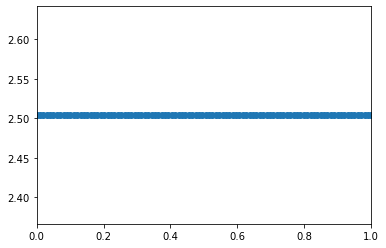

In [66]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(x[:],u_pred[:,0]*rhoref)
#ax.scatter(x[:],u_pred[:,1]*pref)
#ax.scatter(x[:],u_pred[:,2]*uref)
#ax.scatter(x[:],u_pred[:,1]*pref/u_pred[:,0]/rhoref/0.4)
#ax.scatter(x[:],d)
#ax.scatter(x[:],f)
#ax.plot(Exact[:,0],Exact[:,1],color='black')
#ax.plot(Exact[:,0],Exact[:,2],color='black')
#ax.plot(Exact[:,0],Exact[:,3],color='black')
#ax.plot(Exact[:,0],Exact[:,4]/0.4,color='black')
ax.set_xlim(0.0, 1.0)
plt.savefig('1.eps', format='eps')
#ax.set_ylim(0.0, 1.2)
plt.show()

In [ ]:
u_pred_i[:,:,k] = u_pred
k = k+1

In [ ]:

u_pred_i = np.zeros((100,3,10))
k = 0

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(x[:],u_pred[:,0])
ax.scatter(x[:],u_pred[:,1])
ax.scatter(x[:],u_pred[:,2])
ax.plot(Exact[:,0],Exact[:,1])
ax.plot(Exact[:,0],Exact[:,2])
ax.plot(Exact[:,0],Exact[:,3])
ax.set_xlim(0.0, 1.0)
#ax.set_ylim(0.2, 1.2)
plt.show()

In [ ]:
Exact = np.loadtxt('123e.dat')
Exact[:,0]

In [ ]:
fig,ax = plt.subplots()
x = np.linspace(0,1,100)
#ax.plot(x,np.max([0.1-x,np.zeros_like(x)],axis=0))
#ax.plot(x,np.exp(100*(0.1-x))/ np.exp(100*(0.1)))
#ax.plot(x,np.exp(100*(-x)))
ax.plot(x,np.exp(100*(x-0.1)))
plt.show()

In [ ]:
np.max([0.1-x,np.zeros_like(x)],axis=0)

In [ ]:
xp= x.flatten()[:,None]
rhop= u_pred[:,0].flatten()[:,None]
up= u_pred[:,1].flatten()[:,None]
pp= u_pred[:,2].flatten()[:,None]
uxy= np.hstack((xp,rhop,up,pp))    
np.savetxt('shockCrho.dat', uxy)

In [ ]:
# first 15000step conservation
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(x[:],u_pred[:,0])
plt.scatter(x[:],u_pred[:,1])
plt.scatter(x[:],u_pred[:,2])
plt.show()

In [ ]:
# first 15000step non-conservation
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(x[:],u_pred[:,0])
plt.scatter(x[:],u_pred[:,1])
plt.scatter(x[:],u_pred[:,2])
plt.show()